<a href="https://colab.research.google.com/github/Lud-lud/clustering_analysis/blob/main/analise_clustering_notas_escolares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de alunos por meio de método de clusterização k-means

O objetivo deste projeto é desenvolver uma classificação dos estudantes com base nas suas notas do boletim escolar para que sejam desenvolvidos materiais de reforço que mais se adequem às suas forças e fraquezas.

Para aqueles alunos com dificuldades em Matemática, mas com facilidade em Ciências da Natureza, podem ser criados exemplos didáticos e questões que ensinem e avaliem o aprendizado de Matemática utilizando contextos oriundos das Ciências da Natureza.

A expectativa é que a associação de novos conhecimentos ao conhecimento pré-existente ajudará os alunos na compreensão e memorização do conteúdo, maximizando o aprendizado.

Vamos simular dados de notas dos alunos do 9º ano para cada disciplina, pois não foi possível encontrar dados públicos até a data de publicação deste projeto. Futuramente, a análise será implementada com dados reais assim que eu consegui-los.

As disciplinas listadas são as que fazem parte da Base Nacional Comum Curricular estabelecida pelo Ministério da Educação. Para tornar o dataset mais realista, vamos criar alunos que possuem as seguintes características:

* Grupo 1: Alunos com notas altas em humanas e baixas em exatas.
* Grupo 2: Alunos com notas altas em exatas e baixas em humanas.
* Grupo 3: Alunos bons em todas as matérias.
* Grupo 4: Alunos ruins em todas as matérias.

In [71]:
!pip install pingouin

In [72]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import pingouin as pg
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings("ignore")

In [73]:
# Configurar número de alunos e disciplinas
num_alunos = 90
disciplinas = ["Língua Portuguesa",
               "Língua Estrangeira",
               "Educação Física",
               "Matemática",
               "Geografia",
               "História",
               "Ciências",
               "Ensino Religioso",
               "Artes",
               "Tecnologia e Informática"]

# Proporção de alunos em cada grupo
proporcoes = [0.3, 0.3, 0.2, 0.2]  # Grupos 1, 2, 3, 4
alunos_por_grupo = [int(num_alunos * p) for p in proporcoes]

# Gerar dados
np.random.seed(42)  # Para reprodutibilidade
dados = {
    "Aluno": [f"Aluno_{i+1}" for i in range(num_alunos)],
}

# Inicializar listas de notas
notas = {disciplina: [] for disciplina in disciplinas}

# Grupo 1: Notas altas em humanas, baixas em exatas
for _ in range(alunos_por_grupo[0]):
    for disciplina in disciplinas:
        if disciplina in ["Língua Portuguesa", "Língua Estrangeira", "Educação Física", "História", "Geografia", "Ensino Religioso", "Artes"]:
            notas[disciplina].append(np.random.uniform(6, 10))  # Notas altas
        else:
            notas[disciplina].append(np.random.uniform(0, 5))  # Notas baixas

# Grupo 2: Notas altas em exatas, baixas em humanas
for _ in range(alunos_por_grupo[1]):
    for disciplina in disciplinas:
        if disciplina in ["Matemática", "Ciências", "Tecnologia e Informática"]:
            notas[disciplina].append(np.random.uniform(6, 10))  # Notas altas
        else:
            notas[disciplina].append(np.random.uniform(0, 5))  # Notas baixas

# Grupo 3: Bons em todas as matérias
for _ in range(alunos_por_grupo[2]):
    for disciplina in disciplinas:
        notas[disciplina].append(np.random.uniform(6, 10))  # Notas altas

# Grupo 4: Ruins em todas as matérias
for _ in range(alunos_por_grupo[3]):
    for disciplina in disciplinas:
        notas[disciplina].append(np.random.uniform(0, 5))  # Notas baixas

# Adicionar as notas ao dicionário de dados
for disciplina in disciplinas:
    dados[disciplina] = notas[disciplina]

# Criar DataFrame
df = pd.DataFrame(dados)

# Mostrar as primeiras linhas do DataFrame
print(df.head())

# Salvar como CSV (opcional)
# df.to_csv("notas_alunos_9ano.csv", index=False)


     Aluno  Língua Portuguesa  Língua Estrangeira  Educação Física  \
0  Aluno_1           7.498160            9.802857         8.927976   
1  Aluno_2           6.082338            9.879639         9.329771   
2  Aluno_3           8.447412            6.557975         7.168579   
3  Aluno_4           8.430179            6.682096         6.260206   
4  Aluno_5           6.488153            7.980708         6.137554   

   Matemática  Geografia  História  Ciências  Ensino Religioso     Artes  \
0    2.993292   6.624075  6.623978  0.290418          9.464705  8.404460   
1    1.061696   6.727300  6.733618  1.521211          8.099026  7.727780   
2    1.831809   7.824280  9.140704  0.998369          8.056938  8.369658   
3    4.744428   9.862528  9.233589  1.523069          6.390688  8.736932   
4    4.546602   7.035120  8.650089  1.558555          8.080272  8.186841   

   Tecnologia e Informática  
0                  3.540363  
1                  1.456146  
2                  0.232252  
3 

É importante ressaltar que, ao lidar com dados reais, é de suma importância fazer a verificação da presença de outliers, pois a análise de clustering é extremamente sensível a valores discrepantes. Com dados simulados, não é necessário.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Aluno                     90 non-null     object 
 1   Língua Portuguesa         90 non-null     float64
 2   Língua Estrangeira        90 non-null     float64
 3   Educação Física           90 non-null     float64
 4   Matemática                90 non-null     float64
 5   Geografia                 90 non-null     float64
 6   História                  90 non-null     float64
 7   Ciências                  90 non-null     float64
 8   Ensino Religioso          90 non-null     float64
 9   Artes                     90 non-null     float64
 10  Tecnologia e Informática  90 non-null     float64
dtypes: float64(10), object(1)
memory usage: 7.9+ KB


In [75]:
df.describe()

,Língua Portuguesa,Língua Estrangeira,Educação Física,Matemática,Geografia,História,Ciências,Ensino Religioso,Artes,Tecnologia e Informática
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,5.051585,5.518371,5.018297,5.292223,5.066598,5.478547,5.118472,5.312782,5.293014,5.053644
std,3.205152,2.931678,3.080553,2.968049,3.163086,2.952531,2.947133,3.013527,2.942806,3.093451
min,0.060772,0.023160,0.071967,0.317792,0.090551,0.131835,0.182748,0.054188,0.065010,0.232252
25%,2.215714,3.223844,2.277345,2.475342,2.361829,2.811013,2.598881,2.714358,2.843890,2.215844
50%,5.516405,5.532470,5.502636,5.431765,5.436345,5.500806,5.455234,5.540818,5.478313,5.548955
75%,8.001104,8.242032,7.811271,8.120852,7.581778,7.955348,7.619103,8.074439,8.002368,7.820704
max,9.878339,9.960215,9.757996,9.850594,9.942602,9.959841,9.944004,9.866619,9.877882,9.944843


In [76]:
# Gráfico 3D dinâmico (não visível no arquivo .ipynb no GitHub)
fig = px.scatter_3d(df,
                   x='Língua Portuguesa',
                   y='Matemática',
                   z='História')
fig.show()

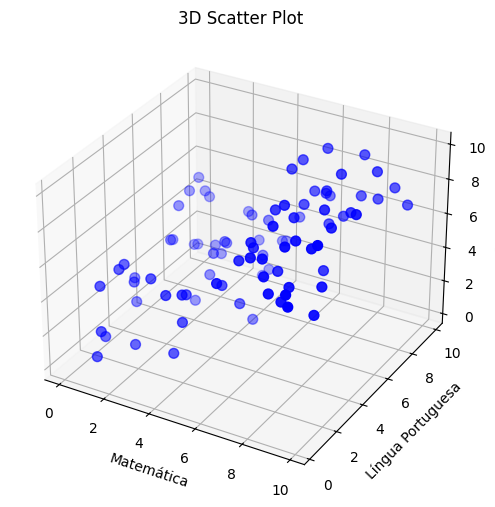

In [77]:
# Dados do gráfico
x = df['Língua Portuguesa']
y = df['Matemática']
z = df['História']

# Criar o gráfico 3D
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection='3d')

# Scatter plot com cores personalizadas
ax.scatter(x, y, z, s=50, c='blue', marker='o')

# Personalizar o gráfico
ax.set_xlabel('Matemática')
ax.set_ylabel('Língua Portuguesa')
ax.set_zlabel('Redação')
plt.title("3D Scatter Plot")

# Salvar e exibir
plt.savefig('3d_scatterplot_escola.png')
plt.show()

Pela análise do gráfico 3D com apenas 3 variáveis já é possível observar a formação de grupos bem distintos, ou seja, distantes entre si, embora existam observações entre os grupos que estão bastante próximas entre si.

Vamos prosseguir com as análises selecionando apenas os dados quantitativos para utilizar no algoritmo de clusterização.

In [78]:
df_num = df.drop(columns=['Aluno'])

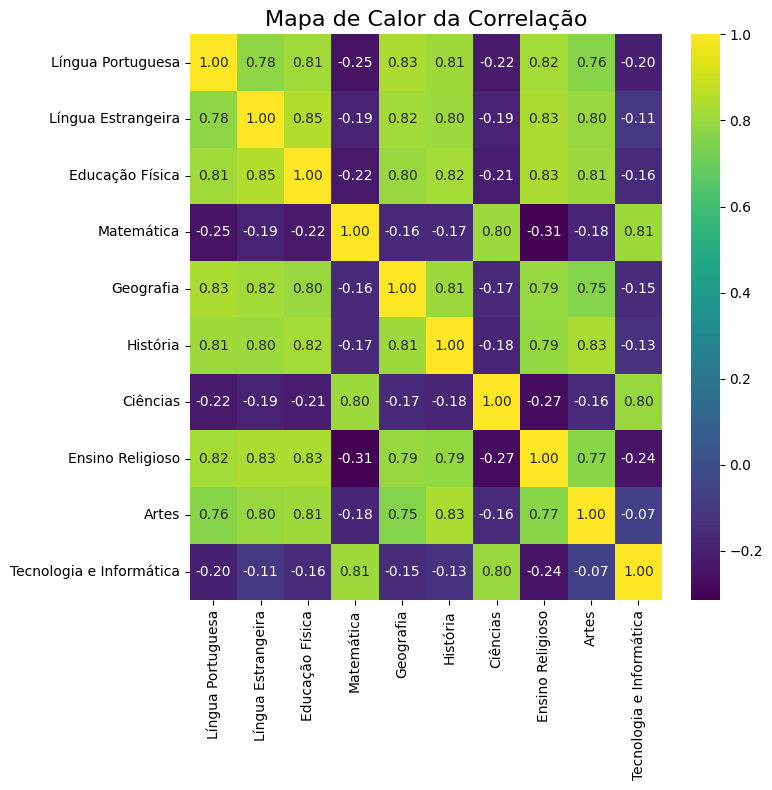

In [79]:
# Calcula a matriz de correlação
corr = df_num.corr()

# Configura o tamanho do gráfico
plt.figure(figsize=(8, 8))

# Cria o mapa de calor usando seaborn
sns.heatmap(
    corr,
    annot=True,         # Exibe os valores no mapa de calor
    fmt=".2f",          # Formato dos valores
    cmap="viridis",     # Paleta de cores
    cbar=True           # Adiciona a barra de cores
)

# Adiciona título e ajusta o layout
plt.title("Mapa de Calor da Correlação", fontsize=16)
plt.tight_layout()
plt.show()

Observa-se que a maioria das disciplinas possui uma correlação positiva forte entre si. Isto indica a possibilidade de aplicar uma Análise de Componentes Principais (PCA) para redução de dimensionalidade. No entanto, como não queremos perder informação, vamos seguir com a análise utilizando as variáveis originais.

In [80]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Língua Portuguesa         90 non-null     float64
 1   Língua Estrangeira        90 non-null     float64
 2   Educação Física           90 non-null     float64
 3   Matemática                90 non-null     float64
 4   Geografia                 90 non-null     float64
 5   História                  90 non-null     float64
 6   Ciências                  90 non-null     float64
 7   Ensino Religioso          90 non-null     float64
 8   Artes                     90 non-null     float64
 9   Tecnologia e Informática  90 non-null     float64
dtypes: float64(10)
memory usage: 7.2 KB


Neste caso, como todas as variáveis a serem utilizadas são notas que variam de 0 a 10, não é necessário fazer a padronização dos dados. Caso as variáveis apresentem escalas diferentes, é indispensável a realização da padronização, que pode ser feita com o procedimento z-scores.

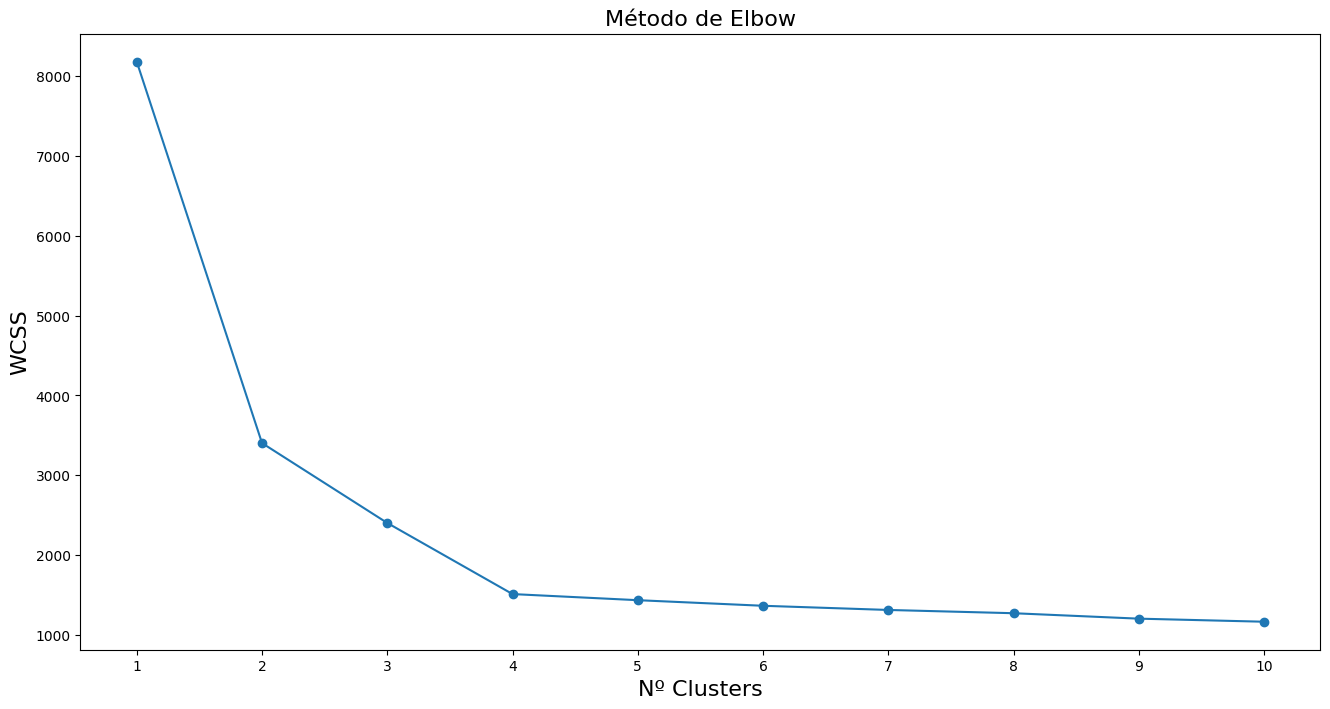

In [81]:
elbow = []
K = range(1,11) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(df_num)
    elbow.append(kmeanElbow.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

A análise da figura acima mostra que o número ideal de clusters é 4. Podemos utilizar o método da silhueta para a qualidade da formação de clusters com cada número de cluster. Quanto maior o valor, menores são as distâncias dentro dos clusters e maiores são as distâncias entre clusters.

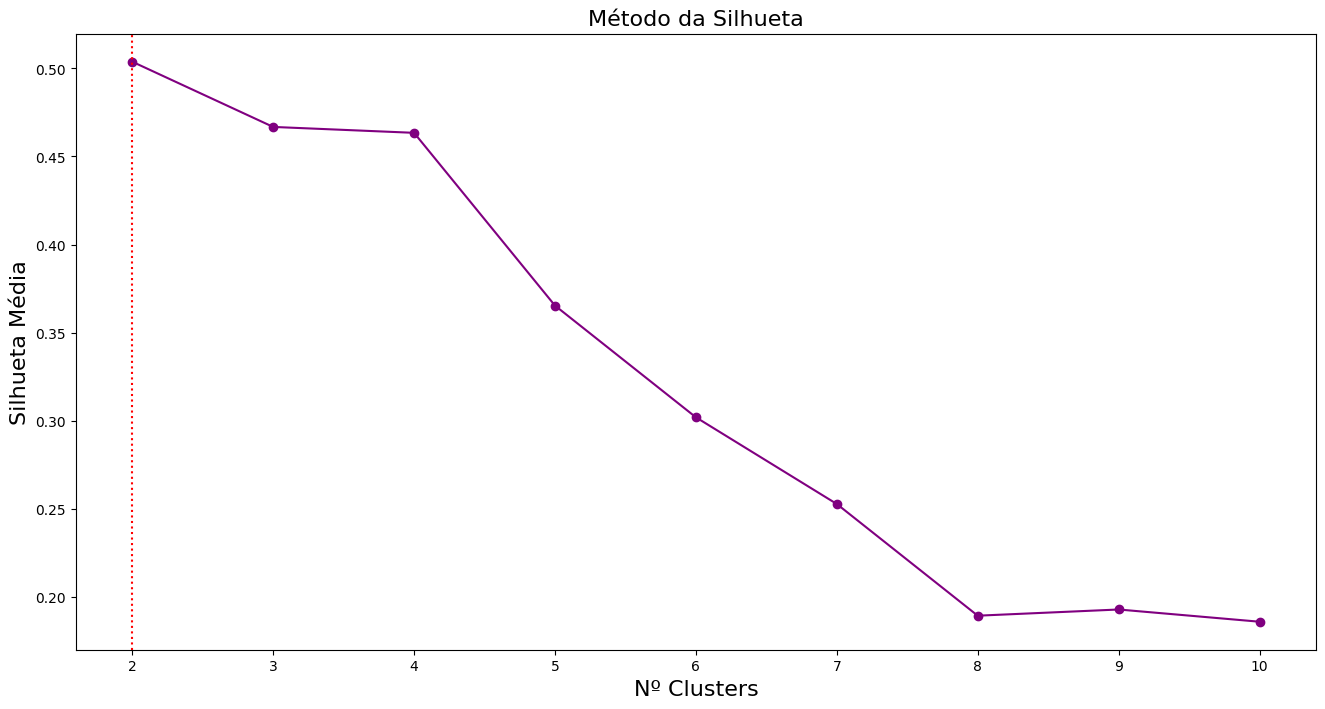

In [82]:
silhueta = []
I = range(2,11) # ponto de parada pode ser parametrizado manualmente
for i in I:
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(df_num)
    silhueta.append(silhouette_score(df_num, kmeansSil.labels_))

plt.figure(figsize=(16,8))
plt.plot(range(2, 11), silhueta, color = 'purple', marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red')
plt.show()


A silhueta mostra que com 2 clusters, a qualidade é melhor. No entanto, com 4 clusters também é possível obter qualidade similar (ligeiramente menor). Vamos manter os 4 clusters para obter grupos mais diversificados.

Outra forma de definir o número de clusters é realizando uma clusterização por meio do esquema de aglomeração hierárquico. Isto é bastante útil para quando não se tem uma ideia sobre quantos clusters pode-se obter a partir dos dados. Neste projeto, Vamos testar o método de encadeamento médio (Average Linkage ou Between Groups), que se comporta de acordo com a proximidade das observações. Neste caso, como há algumas observações próximas entre si (conforme visualizado no gráfico 3D), ele irá se comportar como o dendograma feito com o método de encadeamento Complete Linkage ao invés do Single Linkage (o qual é ideal para quando as observações estão mais distantes entre si). Como medida de distância, vamos utilizar a euclidiana, a mais utilizada para este tipo de análise.

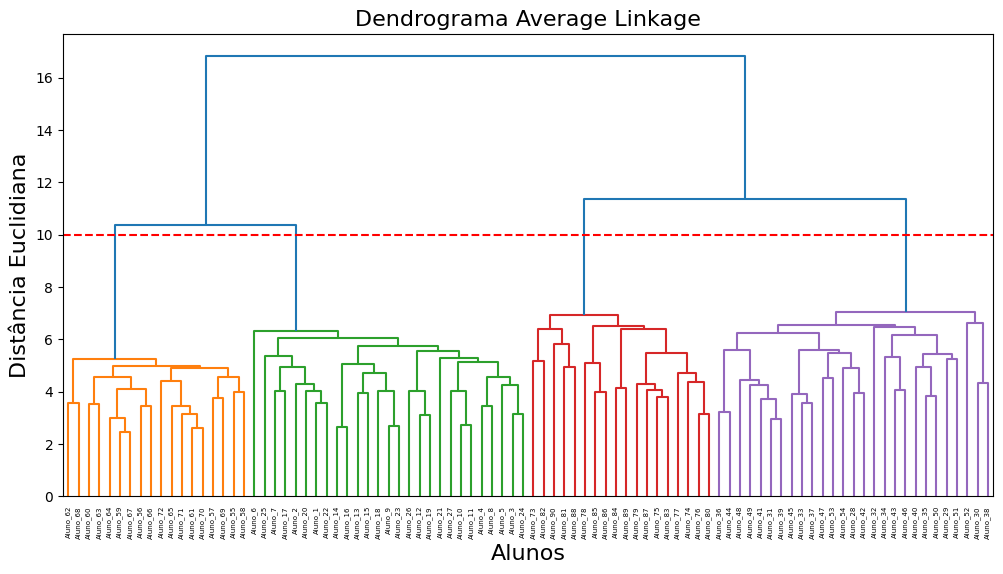

In [83]:
plt.figure(figsize=(12,6))
dend_sing = sch.linkage(df_num, method = 'average', metric = 'euclidean')
dendrogram_s = sch.dendrogram(dend_sing, color_threshold = 10, labels = list(df.Aluno))
plt.title('Dendrograma Average Linkage', fontsize=16)
plt.xlabel('Alunos', fontsize=16)
plt.ylabel('Distância Euclidiana', fontsize=16)
plt.axhline(y = 10, color = 'red', linestyle = '--')
plt.show()

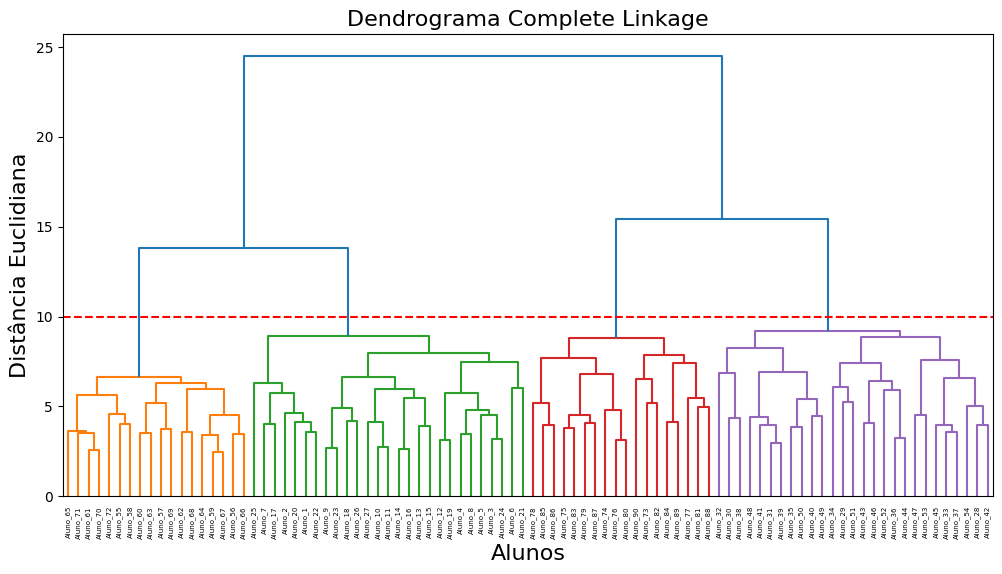

In [84]:
plt.figure(figsize=(12,6))
dend_sing = sch.linkage(df_num, method = 'complete', metric = 'euclidean')
dendrogram_s = sch.dendrogram(dend_sing, color_threshold = 10, labels = list(df.Aluno))
plt.title('Dendrograma Complete Linkage', fontsize=16)
plt.xlabel('Alunos', fontsize=16)
plt.ylabel('Distância Euclidiana', fontsize=16)
plt.axhline(y = 10, color = 'red', linestyle = '--')
plt.show()

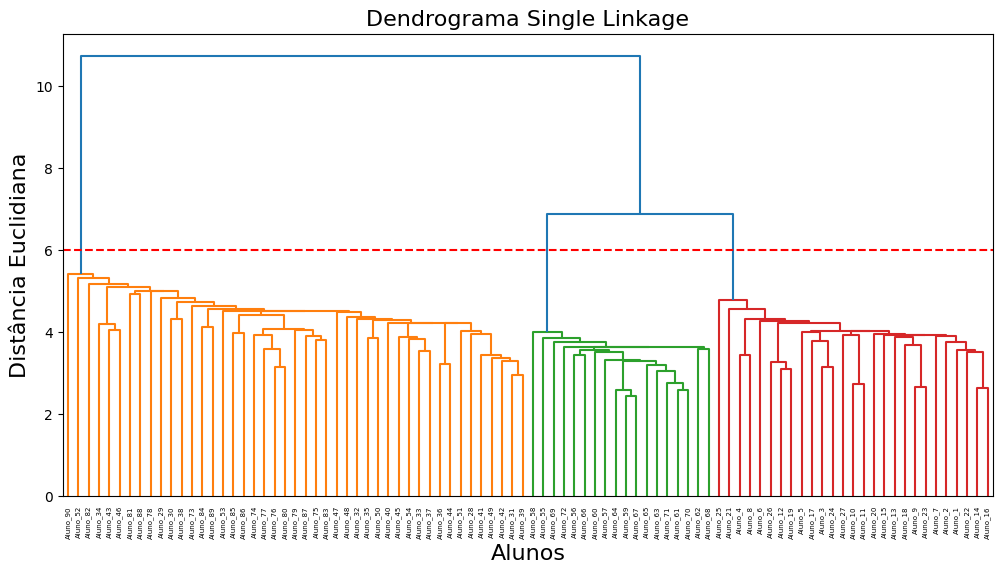

In [85]:
plt.figure(figsize=(12,6))
dend_sing = sch.linkage(df_num, method = 'single', metric = 'euclidean')
dendrogram_s = sch.dendrogram(dend_sing, color_threshold = 6, labels = list(df.Aluno))
plt.title('Dendrograma Single Linkage', fontsize=16)
plt.xlabel('Alunos', fontsize=16)
plt.ylabel('Distância Euclidiana', fontsize=16)
plt.axhline(y = 6, color = 'red', linestyle = '--')
plt.show()

Apesar do dendograma gerado pelo método de encadeamento Single Linkage demonstrar a formação de 3 clusters, os dois dendogramas anteriores sugerem a formação de 4 clusters. Portanto, vamos manter 4 clusters na análise de clustering k-means.

In [86]:
kmeans_final = KMeans(n_clusters = 4, init = 'random', random_state=100).fit(df_num)

# Gerando a variável para identificarmos os clusters gerados

kmeans_clusters = kmeans_final.labels_
df['cluster_kmeans'] = kmeans_clusters


In [87]:
df.head()

,Aluno,Língua Portuguesa,Língua Estrangeira,Educação Física,Matemática,Geografia,História,Ciências,Ensino Religioso,Artes,Tecnologia e Informática,cluster_kmeans
0,Aluno_1,7.498160,9.802857,8.927976,2.993292,6.624075,6.623978,0.290418,9.464705,8.404460,3.540363,0
1,Aluno_2,6.082338,9.879639,9.329771,1.061696,6.727300,6.733618,1.521211,8.099026,7.727780,1.456146,0
2,Aluno_3,8.447412,6.557975,7.168579,1.831809,7.824280,9.140704,0.998369,8.056938,8.369658,0.232252,0
3,Aluno_4,8.430179,6.682096,6.260206,4.744428,9.862528,9.233589,1.523069,6.390688,8.736932,2.200762,0
4,Aluno_5,6.488153,7.980708,6.137554,4.546602,7.035120,8.650089,1.558555,8.080272,8.186841,0.924272,0


In [88]:
pal = {'0': '#ef476f', '1': '#ffd166', '2': '#06d6a0', '3': '#118ab2'}

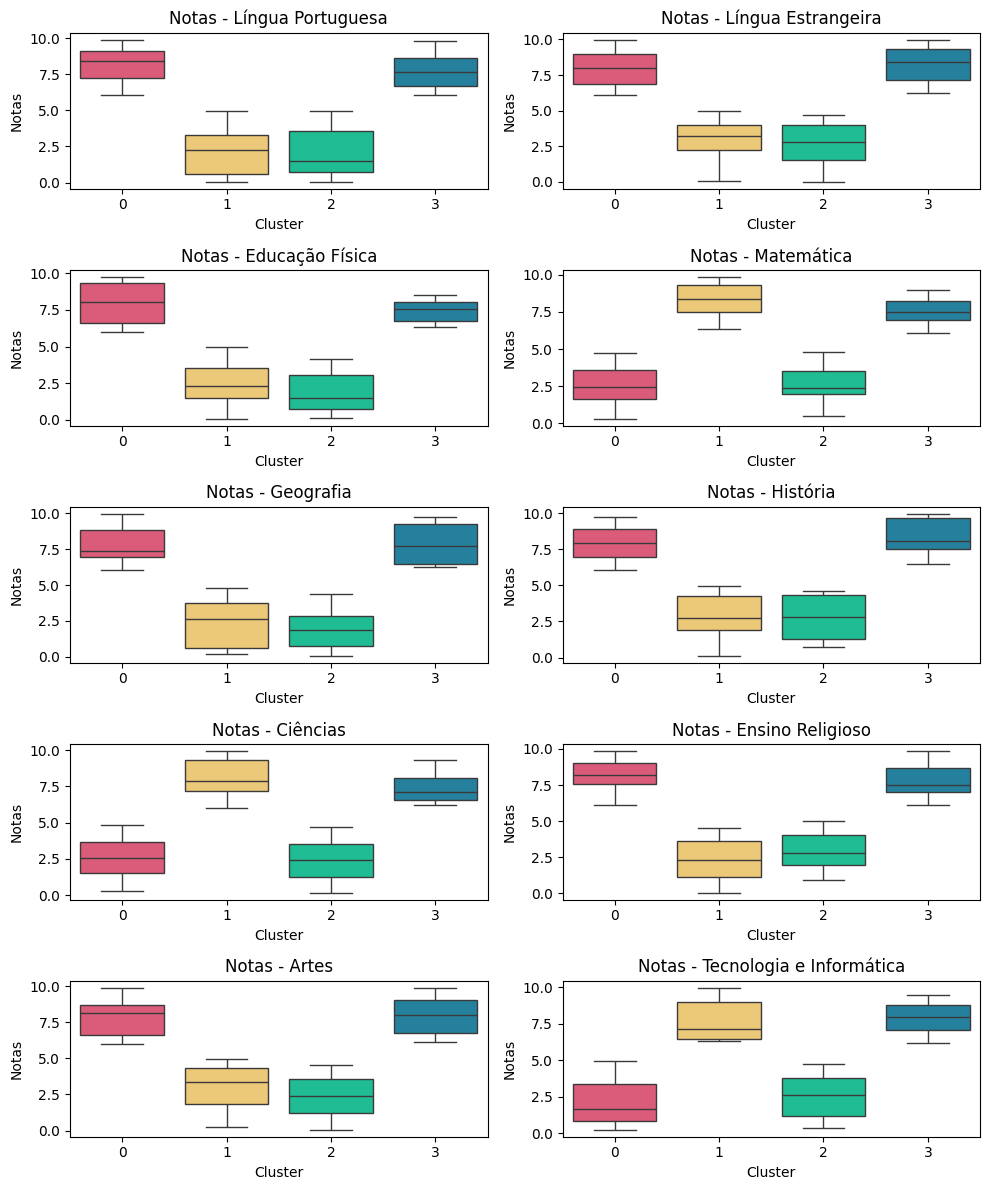

In [89]:
fig, axes = plt.subplots(5, 2, figsize=(10, 12))  # Grade de 5x2 para os subplots
axes = axes.flatten()  # Transforma os eixos em uma lista para iteração

for i, disciplina in enumerate(disciplinas):
    sns.boxplot(
        x=df["cluster_kmeans"],
        y=df[disciplina],
        ax=axes[i],
        palette=pal
    )
    axes[i].set_title(f'Notas - {disciplina}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Notas')

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

Com os boxplots é possível visualizar a variabilidade entre os grupos e dentro dos grupos. Observa-se o seguinte padrão:
*  Cluster 0: Alto a médio desempenho em Humanas e baixo desempenho em Exatas;
*  Cluster 1: Alto desempenho em Humanas, com alto a médio desempenho em Exatas;
*  Cluster 2: Baixo desempenho em todas as disciplinas;
*  Cluster 3: Alto a médio desempenho em todas as disciplinas.

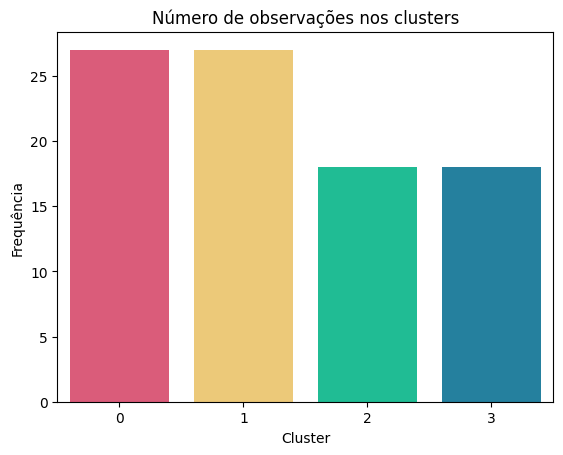

In [90]:
sns.countplot(x=df["cluster_kmeans"].sort_values().astype(str),
              palette=pal, dodge=False)
plt.title("Número de observações nos clusters")
plt.xlabel("Cluster")
plt.ylabel("Frequência")
plt.show()

Avaliar quais disciplinas contribuíram para a formação dos grupos por meio do teste estatístico F de análise de variância de um fator (ANOVA one-way), que nos diz se pelo menos 1 cluster é estatisticamente diferente dos demais considerando cada variável.



In [91]:
p_valor = pd.DataFrame({'Disciplina': df_num.columns, 'p_valor': [None] * len(df_num.columns)})

for i, coluna in enumerate(df_num.columns):
    anova = pg.anova(dv=coluna,
                     between='cluster_kmeans',
                     data=df,
                     detailed=True)
    p_val = anova['p-unc'].iloc[0]  # Seleciona o primeiro valor de p-unc
    p_valor.loc[i, 'p_valor'] = p_val

print(p_valor)


                 Disciplina p_valor
0         Língua Portuguesa     0.0
1        Língua Estrangeira     0.0
2           Educação Física     0.0
3                Matemática     0.0
4                 Geografia     0.0
5                  História     0.0
6                  Ciências     0.0
7          Ensino Religioso     0.0
8                     Artes     0.0
9  Tecnologia e Informática     0.0


Todas as variáveis contribuíram para a formação dos grupos.
Agora vamos gerar um scatterplot para visualização das observações dentro dos clusters e seus respectivos centroides.

In [92]:
centroides = pd.DataFrame(kmeans_final.cluster_centers_)
centroides.columns = df_num.columns
centroides.index.name = 'cluster'
centroides

,Língua Portuguesa,Língua Estrangeira,Educação Física,Matemática,Geografia,História,Ciências,Ensino Religioso,Artes,Tecnologia e Informática
cluster,,,,,,,,,,
0,8.109501,8.007463,8.000965,2.545058,7.902531,7.957881,2.511262,8.170154,7.853034,2.147568
1,2.198227,3.071712,2.478721,8.293752,2.449986,2.864235,8.031348,2.331907,2.946797,7.767370
2,2.137133,2.677160,1.895068,2.642284,1.920297,2.836585,2.435900,2.981143,2.376098,2.493445
3,7.659199,8.295935,7.476889,7.560616,7.883916,8.322975,7.342546,7.829677,7.889227,7.902367


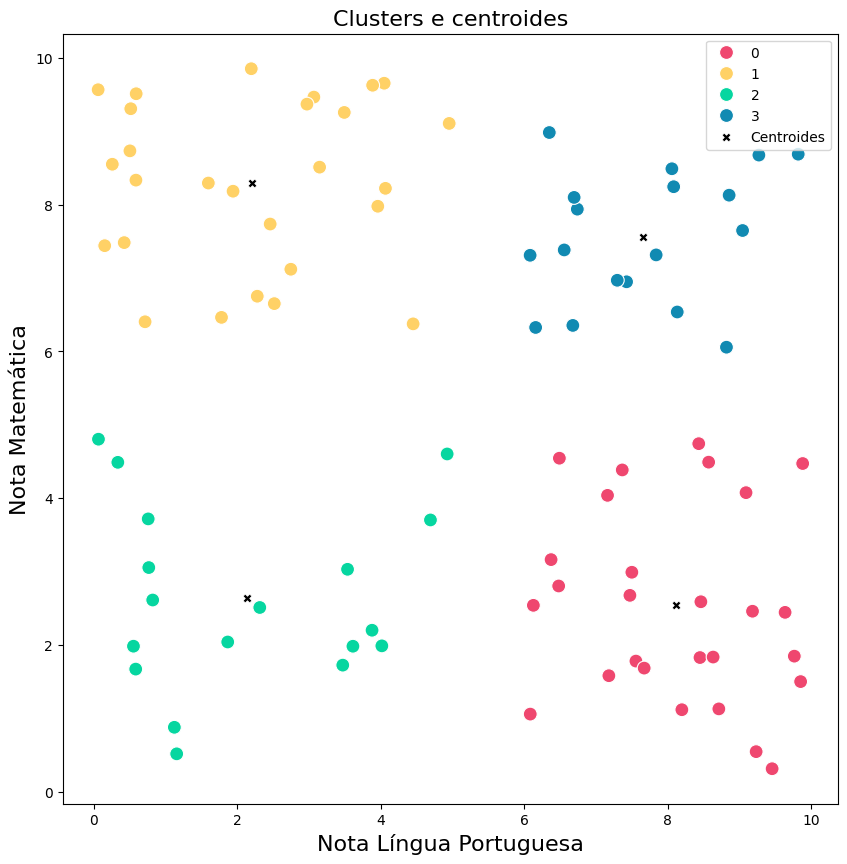

In [93]:
pal = {0: '#ef476f', 1: '#ffd166', 2: '#06d6a0', 3: '#118ab2'}

plt.figure(figsize=(10,10))
sns.scatterplot(x='Língua Portuguesa', y='Matemática', data=df, hue='cluster_kmeans', palette=pal, s=100)
sns.scatterplot(x='Língua Portuguesa', y='Matemática', data=centroides, s=40, c='black', label='Centroides', marker="X")
plt.title('Clusters e centroides', fontsize=16)
plt.xlabel('Nota Língua Portuguesa', fontsize=16)
plt.ylabel('Nota Matemática', fontsize=16)
plt.legend(loc='upper right')
plt.show()

Vamos gerar uma visualização 3D dos clusters.

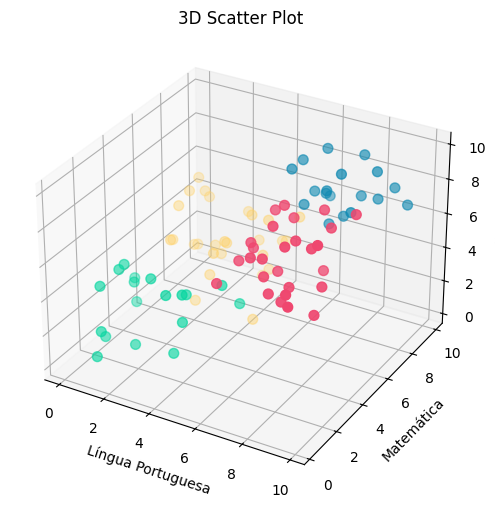

In [94]:
# Mapear as cores para cada ponto
cores = df["cluster_kmeans"].map(pal)

# Dados do gráfico
x = df['Língua Portuguesa']
y = df['Matemática']
z = df['História']

# Criar o gráfico 3D
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection='3d')

# Scatter plot com cores personalizadas
ax.scatter(x, y, z, s=50, c=cores, marker='o')

# Personalizar o gráfico
ax.set_xlabel('Língua Portuguesa')
ax.set_ylabel('Matemática')
ax.set_zlabel('História')
plt.title("3D Scatter Plot")

# Salvar e exibir
plt.savefig('3d_scatterplot_escola.png')
plt.show()


Agora, vamos caracterizar os grupos para que seja possível descrevê-los melhor. Para isso, primeiramente vou categorizar as notas dos alunos com base em classes e, em seguida, calcular o percentual dessas classes dentro dos clusters.
O critério de categorização é totalmente arbitrário, devendo ser discutido sobre o significado e os limites que façam mais sentido para as metas da instituição:
*  Baixo desempenho: notas de 0 a menos de 5;
*  Médio desempenho: notas de 5 a menos de 7;
*  Alto desempenho: notas de 7 a 10.

In [95]:
df_class = df.copy()

for coluna in df_class.columns[1:11]:
  df_class[coluna] = df_class[coluna].apply(
      lambda valor: "Baixo desempenho" if valor <= 5
      else "Médio desempenho" if valor > 5 and valor < 7
      else "Alto desempenho"
  )

In [96]:
df_class.head()

,Aluno,Língua Portuguesa,Língua Estrangeira,Educação Física,Matemática,Geografia,História,Ciências,Ensino Religioso,Artes,Tecnologia e Informática,cluster_kmeans
0,Aluno_1,Alto desempenho,Alto desempenho,Alto desempenho,Baixo desempenho,Médio desempenho,Médio desempenho,Baixo desempenho,Alto desempenho,Alto desempenho,Baixo desempenho,0
1,Aluno_2,Médio desempenho,Alto desempenho,Alto desempenho,Baixo desempenho,Médio desempenho,Médio desempenho,Baixo desempenho,Alto desempenho,Alto desempenho,Baixo desempenho,0
2,Aluno_3,Alto desempenho,Médio desempenho,Alto desempenho,Baixo desempenho,Alto desempenho,Alto desempenho,Baixo desempenho,Alto desempenho,Alto desempenho,Baixo desempenho,0
3,Aluno_4,Alto desempenho,Médio desempenho,Médio desempenho,Baixo desempenho,Alto desempenho,Alto desempenho,Baixo desempenho,Médio desempenho,Alto desempenho,Baixo desempenho,0
4,Aluno_5,Médio desempenho,Alto desempenho,Médio desempenho,Baixo desempenho,Alto desempenho,Alto desempenho,Baixo desempenho,Alto desempenho,Alto desempenho,Baixo desempenho,0


In [97]:
for disciplina in df_class.columns[1:11]:
  for cl in df_class.cluster_kmeans.unique():
    # Calculate the percentage of each performance category
    vc = 100*df_class.loc[df_class.cluster_kmeans==cl,disciplina].value_counts()/(df.cluster_kmeans==cl).sum()

    # Iterate through categories and percentages
    for cat,cnt in vc.reset_index().values:
      # Print cluster, subject, and percentage of each category instead of mean
      print(f'{cl:d}; {disciplina}; {cat}; {cnt:.2f}%'.replace('.',','))

0; Língua Portuguesa; Alto desempenho; 81,48%
0; Língua Portuguesa; Médio desempenho; 18,52%
1; Língua Portuguesa; Baixo desempenho; 100,00%
3; Língua Portuguesa; Alto desempenho; 61,11%
3; Língua Portuguesa; Médio desempenho; 38,89%
2; Língua Portuguesa; Baixo desempenho; 100,00%
0; Língua Estrangeira; Alto desempenho; 66,67%
0; Língua Estrangeira; Médio desempenho; 33,33%
1; Língua Estrangeira; Baixo desempenho; 100,00%
3; Língua Estrangeira; Alto desempenho; 83,33%
3; Língua Estrangeira; Médio desempenho; 16,67%
2; Língua Estrangeira; Baixo desempenho; 100,00%
0; Educação Física; Alto desempenho; 70,37%
0; Educação Física; Médio desempenho; 29,63%
1; Educação Física; Baixo desempenho; 100,00%
3; Educação Física; Alto desempenho; 61,11%
3; Educação Física; Médio desempenho; 38,89%
2; Educação Física; Baixo desempenho; 100,00%
0; Matemática; Baixo desempenho; 100,00%
1; Matemática; Alto desempenho; 81,48%
1; Matemática; Médio desempenho; 18,52%
3; Matemática; Alto desempenho; 66,67%
3

In [98]:
for disciplina in df_class.columns[1:11]:

    # Calculate the percentage of each performance category
    vc = 100*df_class.loc[:,disciplina].value_counts()/(df_class.shape[0])

    # Iterate through categories and percentages
    for cat,cnt in vc.reset_index().values:
      # Print cluster, subject, and percentage of each category instead of mean
      print(f'All; {disciplina}; {str(cat):s}; {cnt:5.2f}%'.replace('.',','))

All; Língua Portuguesa; Baixo desempenho; 50,00%
All; Língua Portuguesa; Alto desempenho; 36,67%
All; Língua Portuguesa; Médio desempenho; 13,33%
All; Língua Estrangeira; Baixo desempenho; 50,00%
All; Língua Estrangeira; Alto desempenho; 36,67%
All; Língua Estrangeira; Médio desempenho; 13,33%
All; Educação Física; Baixo desempenho; 50,00%
All; Educação Física; Alto desempenho; 33,33%
All; Educação Física; Médio desempenho; 16,67%
All; Matemática; Baixo desempenho; 50,00%
All; Matemática; Alto desempenho; 37,78%
All; Matemática; Médio desempenho; 12,22%
All; Geografia; Baixo desempenho; 50,00%
All; Geografia; Alto desempenho; 35,56%
All; Geografia; Médio desempenho; 14,44%
All; História; Baixo desempenho; 50,00%
All; História; Alto desempenho; 36,67%
All; História; Médio desempenho; 13,33%
All; Ciências; Baixo desempenho; 50,00%
All; Ciências; Alto desempenho; 35,56%
All; Ciências; Médio desempenho; 14,44%
All; Ensino Religioso; Baixo desempenho; 50,00%
All; Ensino Religioso; Alto dese

Nesta etapa, continuaremos a análise no Excel para realizar tabelas dinâmicas e análises visuais. O arquivo .xlsx e as conclusões da análise (no arquivo README) encontram-se no repositório.